Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [8]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

Annotate Images with labelme

In [9]:
!labelme

Review Dataset and build image loading function

import tf and deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

limit gpu memory growth

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

Load Image into TF Data Pipeline

In [6]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [7]:
images.as_numpy_iterator().next()

b'data\\images\\10cd3f2d-ca16-11ed-83dd-8c47be145510.jpg'

In [8]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [9]:
images = images.map(load_image)

In [10]:
images.as_numpy_iterator().next()

array([[[ 82,  83,  78],
        [ 82,  83,  78],
        [ 83,  84,  79],
        ...,
        [124, 132, 135],
        [123, 133, 135],
        [124, 134, 136]],

       [[ 82,  83,  78],
        [ 82,  83,  78],
        [ 82,  83,  78],
        ...,
        [123, 131, 134],
        [123, 133, 135],
        [124, 134, 136]],

       [[ 83,  84,  79],
        [ 82,  83,  78],
        [ 82,  83,  78],
        ...,
        [124, 132, 135],
        [124, 131, 137],
        [125, 132, 138]],

       ...,

       [[ 50,  43,  35],
        [ 51,  44,  36],
        [ 52,  45,  39],
        ...,
        [ 96,  35,   6],
        [ 99,  35,   7],
        [ 99,  35,   7]],

       [[ 47,  43,  34],
        [ 47,  43,  34],
        [ 48,  43,  37],
        ...,
        [ 98,  37,   9],
        [101,  37,  10],
        [102,  38,  11]],

       [[ 47,  43,  34],
        [ 47,  43,  34],
        [ 48,  43,  37],
        ...,
        [100,  39,  11],
        [103,  39,  12],
        [104,  40,  13]]

In [11]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

View Raw Images with Matplotlib

In [12]:
image_generator = images.batch(4).as_numpy_iterator()

In [17]:
plot_images = image_generator.next()

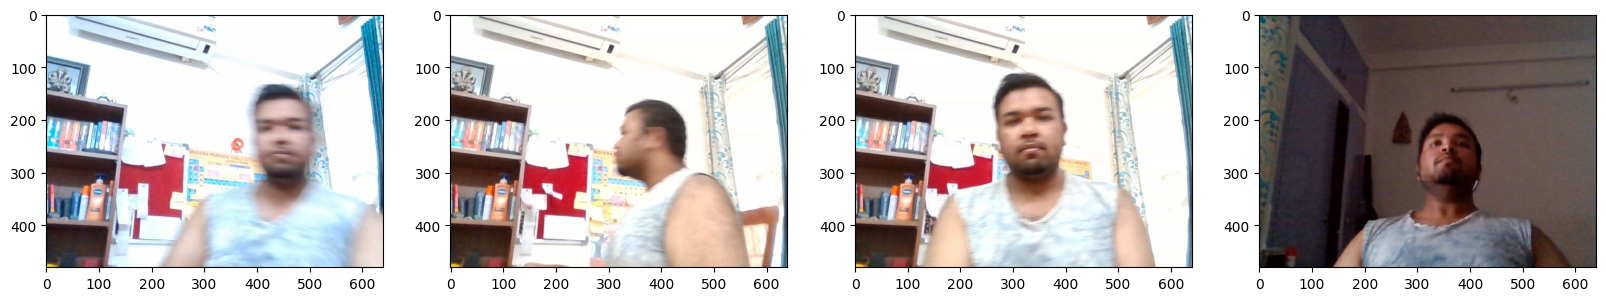

In [18]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

Partition Unaugmented Data

MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [22]:
120*0.7 #84 to train

84.0

In [26]:
120*.15 #18 to test and val

18.0

Move the Matching Labels

In [28]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

Apply Image Augmentation on Images and Labels using Albumentations

Setup Albumentations Transform Pipeline

In [29]:

import albumentations as alb

In [31]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2), alb.RandomGamma(p=0.2),  alb.RGBShift(p=0.2),  alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', label_fields=['class_labels']))

Load a Test Image and Annotation with OpenCV and JSON

In [41]:
img = cv2.imread(os.path.join('data','train', 'images','37af549f-ca16-11ed-adbb-8c47be145510.jpg'))
img.shape

(480, 640, 3)

In [34]:
with open(os.path.join('data', 'train', 'labels', '37af549f-ca16-11ed-adbb-8c47be145510.json'), 'r') as f:
    label = json.load(f)

In [36]:
label['shapes'][0]['points']

[[365.89371980676333, 109.08212560386472],
 [621.9323671497584, 400.3864734299517]]

Extract Coordinates and Rescale to Match Image Resolution

In [37]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [38]:

coords

[365.89371980676333, 109.08212560386472, 621.9323671497584, 400.3864734299517]

In [39]:
coords = list(np.divide(coords, [640,480,640,480]))

In [40]:

coords

[0.5717089371980677,
 0.22725442834138485,
 0.9717693236714975,
 0.8341384863123994]

Apply Augmentations and View Results

In [42]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [43]:

augmented['bboxes'][0][2:]

(1.0, 0.7664841653247451)

In [44]:

augmented['bboxes']

[(0.6642082662372518, 0.11914117015566283, 1.0, 0.7664841653247451)]

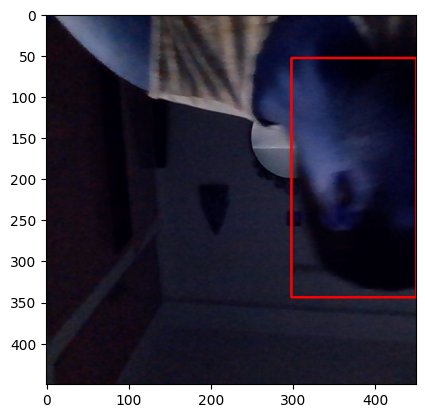

In [45]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

Build and Run Augmentation Pipeline

Run Augmentation Pipeline

In [47]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.7600392512077294, 0.9589371980676329, 0.40451388888888895, 0.2916666666666667, 'face'].


Load Augmented Images to Tensorflow Dataset

In [48]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [49]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [50]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [51]:
train_images.as_numpy_iterator().next()

array([[[0.6071078 , 0.6115809 , 0.58952206],
        [0.62941176, 0.6387255 , 0.61960787],
        [0.61881125, 0.63596815, 0.6276348 ],
        ...,
        [0.8380515 , 0.8223652 , 0.81844366],
        [0.8362745 , 0.82058823, 0.81666666],
        [0.84221816, 0.8265319 , 0.8226103 ]],

       [[0.5484681 , 0.5598652 , 0.55692405],
        [0.593076  , 0.61268383, 0.5891544 ],
        [0.6245711 , 0.64319855, 0.6148897 ],
        ...,
        [0.84705883, 0.8235294 , 0.8235294 ],
        [0.847549  , 0.83186275, 0.8279412 ],
        [0.8495098 , 0.8338235 , 0.82990193]],

       [[0.47401962, 0.4908701 , 0.50735295],
        [0.5613971 , 0.57800245, 0.57120097],
        [0.6167892 , 0.6285539 , 0.59411764],
        ...,
        [0.84705883, 0.83137256, 0.827451  ],
        [0.8509804 , 0.8352941 , 0.83137256],
        [0.85018384, 0.8344976 , 0.830576  ]],

       ...,

       [[0.9647059 , 0.9843137 , 1.        ],
        [0.9647059 , 0.9843137 , 1.        ],
        [0.9647059 , 0

Prepare Labels

Build Label Loading Function

In [52]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

Load Labels to Tensorflow Dataset

In [53]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [54]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [55]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [56]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.0843 , 0.09216, 0.631  , 0.762  ], dtype=float16))

Combine Label and Image Samples

Check Partition Lengths

In [57]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(4980, 4980, 1080, 1080, 1080, 1080)

Create Final Datasets (Images/Labels)

In [58]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [59]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [60]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [61]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.308  , 0.1813 , 0.79   , 0.7515 ],
        [0.2795 , 0.2969 , 0.6167 , 0.7217 ],
        [0.209  , 0.2993 , 0.575  , 0.757  ],
        [0.4026 , 0.0785 , 1.     , 0.7485 ],
        [0.5894 , 0.3186 , 0.981  , 0.8286 ],
        [0.06287, 0.3467 , 0.5645 , 0.9014 ],
        [0.833  , 0.2979 , 1.     , 0.7046 ],
        [0.5264 , 0.1259 , 1.     , 0.773  ]], dtype=float16))

View Images and Annotations

In [62]:
data_samples = train.as_numpy_iterator()

In [63]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


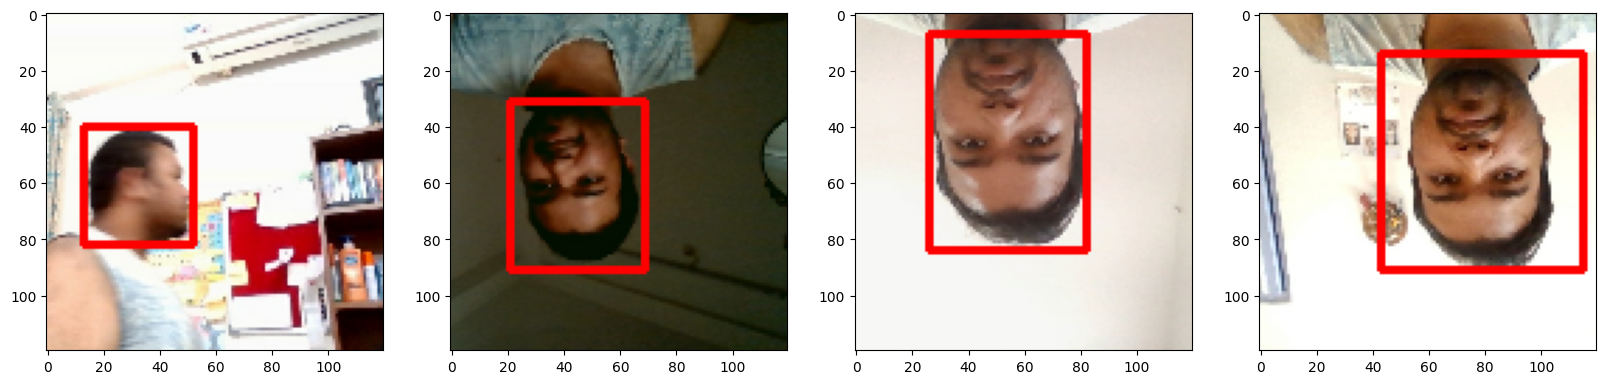

In [64]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

Build Deep Learning using the Functional API

Import Layers and Base Network

In [65]:
from keras.models import Model
from keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16

Download VGG16

In [66]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 9s 0us/step


In [67]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

Build instance of Network

In [68]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

Test out Neural Network

In [69]:
facetracker = build_model()

In [70]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [71]:
X, y = train.as_numpy_iterator().next()

In [72]:
X.shape

(8, 120, 120, 3)

In [73]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [74]:
classes, coords

(array([[0.39130923],
        [0.3734192 ],
        [0.33155745],
        [0.32728836],
        [0.3694051 ],
        [0.37680972],
        [0.45579845],
        [0.47904542]], dtype=float32),
 array([[0.5756732 , 0.5031014 , 0.53736883, 0.63181734],
        [0.65467465, 0.57447916, 0.5671047 , 0.69549036],
        [0.6727159 , 0.48098812, 0.42377198, 0.74270487],
        [0.5167433 , 0.5635746 , 0.50610775, 0.5218849 ],
        [0.69501907, 0.61928815, 0.61462814, 0.7183096 ],
        [0.63029426, 0.5870492 , 0.52856565, 0.65751296],
        [0.5398387 , 0.69155717, 0.48876613, 0.56652236],
        [0.5712374 , 0.5507353 , 0.43682796, 0.61102575]], dtype=float32))

Define Losses and Optimizers

Define Optimizer and LR

In [75]:
len(train)

623

In [76]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [78]:
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)

Create Localization Loss and Classification Loss

In [79]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [80]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

Test out Loss Metrics

In [81]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.444175>

In [82]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.95471466>

In [83]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=6.444175>

Train Neural Network

Create Custom Model Class

In [84]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [85]:
model = FaceTracker(facetracker)

In [86]:
model.compile(opt, classloss, regressloss)

Train

In [87]:
logdir='logs'

In [88]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [89]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
623/623 [==============================] - 827s 1s/step - total_loss: 0.1772 - class_loss: 0.0411 - regress_loss: 0.1566 - val_total_loss: 0.5380 - val_class_loss: 0.4936 - val_regress_loss: 0.2912
Epoch 2/10
623/623 [==============================] - 802s 1s/step - total_loss: 0.1032 - class_loss: 0.0308 - regress_loss: 0.0878 - val_total_loss: 1.7001 - val_class_loss: 1.3330 - val_regress_loss: 1.0336
Epoch 3/10
623/623 [==============================] - 776s 1s/step - total_loss: 0.0253 - class_loss: 0.0057 - regress_loss: 0.0225 - val_total_loss: 0.0196 - val_class_loss: 1.0304e-04 - val_regress_loss: 0.0196
Epoch 4/10
623/623 [==============================] - 781s 1s/step - total_loss: 0.0210 - class_loss: 0.0049 - regress_loss: 0.0186 - val_total_loss: 0.6308 - val_class_loss: 0.1170 - val_regress_loss: 0.5723
Epoch 5/10
623/623 [==============================] - 768s 1s/step - total_loss: 0.0448 - class_loss: 0.0134 - regress_loss: 0.0382 - val_total_loss: 0.1322 - v

Plot Performance

In [90]:
hist.history

{'total_loss': [0.013218180276453495,
  0.005612735636532307,
  0.0074000246822834015,
  0.01558487769216299,
  0.06897470355033875,
  0.004074019845575094,
  0.00450527248904109,
  0.009113398380577564,
  0.004316672682762146,
  0.009966795332729816],
 'class_loss': [0.00031317194225266576,
  0.000840025139041245,
  7.011329580564052e-05,
  0.018803171813488007,
  0.038140565156936646,
  0.0001636949018575251,
  8.95329867489636e-05,
  6.535997817991301e-05,
  1.901425639516674e-05,
  5.2007559133926407e-05],
 'regress_loss': [0.01306159421801567,
  0.005192723125219345,
  0.007364967837929726,
  0.006183291785418987,
  0.04990442097187042,
  0.003992172423750162,
  0.0044605061411857605,
  0.009080718271434307,
  0.004307165741920471,
  0.009940791875123978],
 'val_total_loss': [0.5379641056060791,
  1.700110912322998,
  0.01961643621325493,
  0.630760908126831,
  0.13222572207450867,
  0.27713486552238464,
  0.035234175622463226,
  0.025434235110878944,
  2.750669479370117,
  0.0285

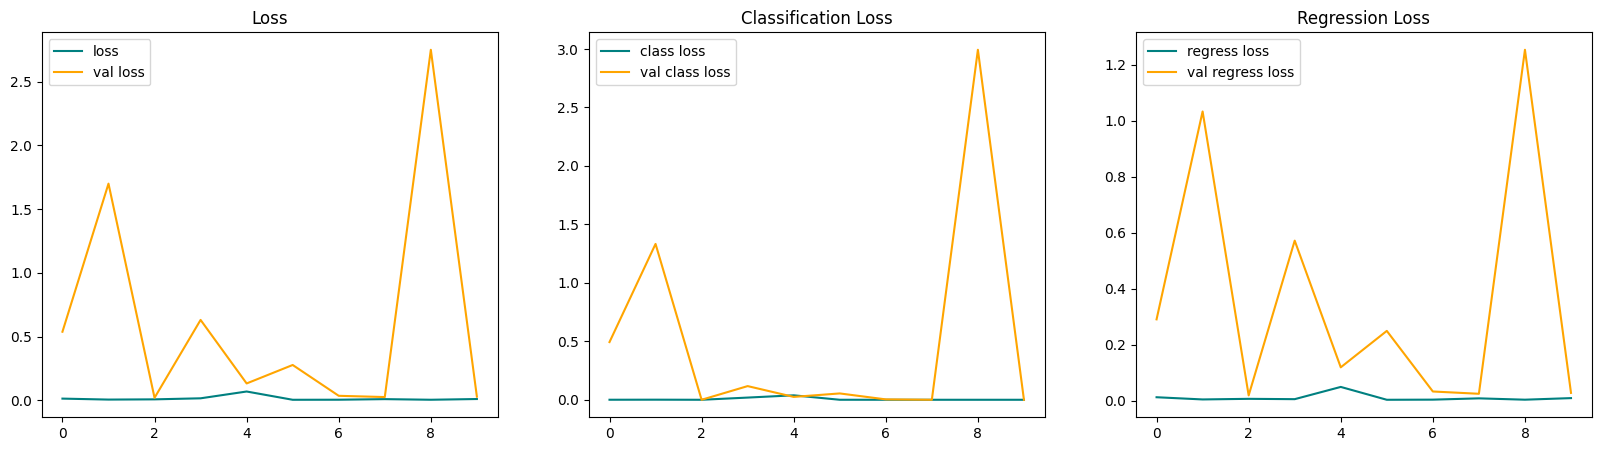

In [91]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

Make Predictions

Make Predictions on Test Set

In [92]:
test_data = test.as_numpy_iterator()

In [93]:
test_sample = test_data.next()

In [94]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 307ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


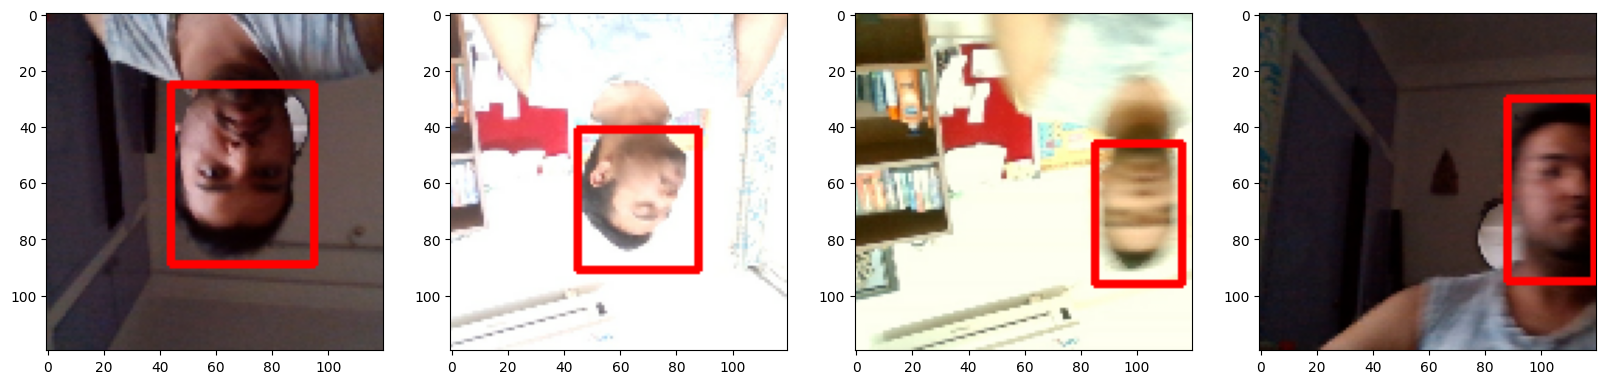

In [95]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

Save the Model

In [96]:
from keras.models import load_model

In [97]:
facetracker.save('facetracker.h5')

In [98]:
facetracker = load_model('facetracker.h5')

Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()